# HYBRID OF TLs

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/16
Train Loss: 0.6540 Acc: 0.7139 | Val Loss: 0.3872 Acc: 0.9135
Validation loss improved. Saved checkpoint best_hybridTL_model.h5
Epoch 2/16
Train Loss: 0.1830 Acc: 0.9446 | Val Loss: 0.3651 Acc: 0.9467
Validation loss improved. Saved checkpoint best_hybridTL_model.h5
Epoch 3/16
Train Loss: 0.0861 Acc: 0.9731 | Val Loss: 0.0518 Acc: 0.9886
Validation loss improved. Saved checkpoint best_hybridTL_model.h5
Epoch 4/16
Train Loss: 0.0675 Acc: 0.9810 | Val Loss: 0.1011 Acc: 0.9755
No improvement for 1 epochs.
Epoch 5/16
Train Loss: 0.0370 Acc: 0.9891 | Val Loss: 0.0287 Acc: 0.9948
Validation loss improved. Saved checkpoint best_hybridTL_model.h5
Epoch 6/16
Train Loss: 0.0321 Acc: 0.9904 | Val Loss: 0.0755 Acc: 0.9834
No improvement for 1 epochs.
Epoch 7/16
Train Loss: 0.0481 Acc: 0.9871 | Val Loss: 0.1399 Acc: 0.9712
No improvement for 2 epochs.
Epoch 8/16
Train Loss: 0.0470 Acc: 0.9851 | Val Loss: 0.0374 Acc: 0.9886
No improvement for 3 epochs.
Epoch 9/16
Train Loss: 0.0236 Acc: 0

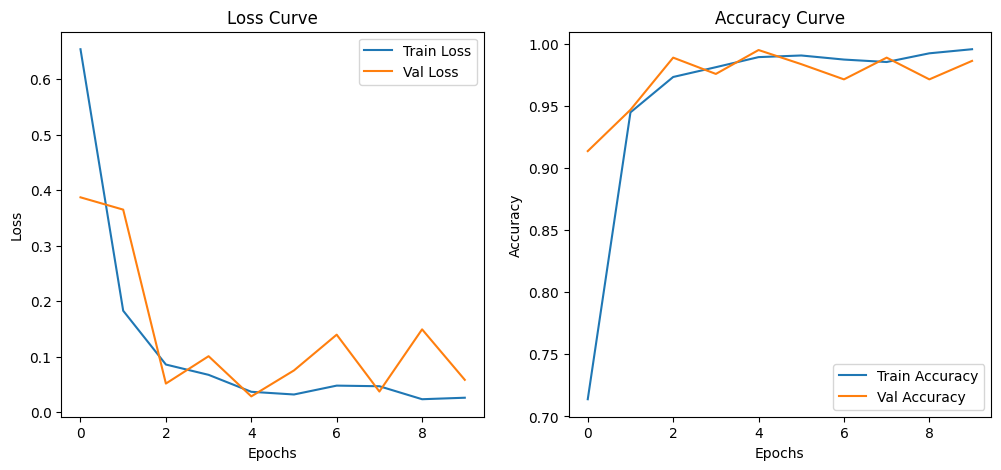

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import timm
import copy
from PIL import Image
import matplotlib.pyplot as plt


class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, seg_mask_paths=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.seg_mask_paths = seg_mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]

        if self.seg_mask_paths is not None and self.seg_mask_paths[idx] is not None and os.path.exists(self.seg_mask_paths[idx]):
            mask = Image.open(self.seg_mask_paths[idx]).convert('L')
            if self.transform:
                mask = self.transform(mask)
        else:
            if isinstance(img, torch.Tensor):
                mask = torch.zeros((1, img.shape[1], img.shape[2]), dtype=torch.float32)
            else:
                mask = torch.zeros((1, img.size[1], img.size[0]), dtype=torch.float32)

        return img, mask, label


def get_train_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


def get_val_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


def get_file_paths_and_labels(data_dir, class_names):
    image_paths = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return image_paths, labels


def create_loaders_from_folders(train_images, train_labels, val_images, val_labels,
                                train_seg_masks=None, val_seg_masks=None,
                                batch_size=32, num_workers=4):

    train_dataset = BrainTumorDataset(
        image_paths=train_images,
        labels=train_labels,
        seg_mask_paths=train_seg_masks,
        transform=get_train_transforms()
    )

    val_dataset = BrainTumorDataset(
        image_paths=val_images,
        labels=val_labels,
        seg_mask_paths=val_seg_masks,
        transform=get_val_transforms()
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader


class SwiGLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc_gate = nn.Linear(input_dim, output_dim)
        self.fc_features = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.silu(self.fc_gate(x)) * self.fc_features(x)


class MHCA(nn.Module):
    def __init__(self, in_channels, heads=4):
        super().__init__()
        self.heads = heads
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, H, W = x.size()
        key = self.key_conv(x).view(batch_size, self.heads, C // self.heads, -1)
        query = self.query_conv(x).view(batch_size, self.heads, C // self.heads, -1)
        value = self.value_conv(x).view(batch_size, self.heads, C // self.heads, -1)

        attn = torch.matmul(query.permute(0, 1, 3, 2), key)  # (B, heads, HW, HW)
        attn = self.softmax(attn / (C // self.heads) ** 0.5)

        out = torch.matmul(attn, value.permute(0, 1, 3, 2))  # (B, heads, HW, channels_per_head)
        out = out.permute(0, 1, 3, 2).contiguous().view(batch_size, C, H, W)

        out = self.gamma * out + x
        return out


class FeatureHarmonizer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.norm1 = nn.BatchNorm1d(input_dim)
        self.fc = nn.Linear(input_dim, output_dim)
        self.norm2 = nn.LayerNorm(output_dim)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.norm1(x)
        x = self.fc(x)
        x = self.norm2(x)
        x = self.activation(x)
        return x


class HybridResNetConvNeXt(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet_layers = nn.Sequential(*list(self.resnet.children())[:-2])  # Remove FC & pool
        self.mhca_resnet = MHCA(in_channels=2048, heads=8)
        self.resnet_pool = nn.AdaptiveAvgPool2d(1)


        self.convnext = timm.create_model('convnext_base', pretrained=True, features_only=True)
        self.mhca_convnext = MHCA(in_channels=1024, heads=8)
        self.convnext_pool = nn.AdaptiveAvgPool2d(1)


        self.harmonizer_resnet = FeatureHarmonizer(2048, 512)
        self.harmonizer_convnext = FeatureHarmonizer(1024, 512)


        fusion_input_dim = 512 * 2
        self.swi_glu_fc1 = SwiGLU(fusion_input_dim, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.swi_glu_fc2 = SwiGLU(512, 256)
        self.dropout2 = nn.Dropout(0.3)


        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):

        res_feat_map = self.resnet_layers(x)
        res_feat_map = self.mhca_resnet(res_feat_map)
        res_feat = self.resnet_pool(res_feat_map).view(x.shape[0], -1)
        res_feat = self.harmonizer_resnet(res_feat)


        conv_feats = self.convnext(x)
        conv_feat_map = conv_feats[-1]
        conv_feat_map = self.mhca_convnext(conv_feat_map)
        conv_feat = self.convnext_pool(conv_feat_map).view(x.shape[0], -1)
        conv_feat = self.harmonizer_convnext(conv_feat)


        fused = torch.cat([res_feat, conv_feat], dim=1)


        x = self.swi_glu_fc1(fused)
        x = self.dropout1(x)
        x = self.swi_glu_fc2(x)
        x = self.dropout2(x)

        logits = self.classifier(x)
        return logits


def train_model(model, train_loader, val_loader, device, epochs=16, lr=1e-4, patience=5, checkpoint_path='best_hybridTL_model.h5'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")


        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, seg_masks, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct.double() / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())


        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, seg_masks, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct.double() / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Validation loss improved. Saved checkpoint {checkpoint_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
    train_dir = '/content/dataset_split/train'
    val_dir = '/content/dataset_split/val'

    train_image_paths, train_labels = get_file_paths_and_labels(train_dir, class_names)
    val_image_paths, val_labels = get_file_paths_and_labels(val_dir, class_names)

    train_seg_mask_paths = None
    val_seg_mask_paths = None

    train_loader, val_loader = create_loaders_from_folders(
        train_image_paths, train_labels,
        val_image_paths, val_labels,
        train_seg_masks=train_seg_mask_paths,
        val_seg_masks=val_seg_mask_paths,
        batch_size=32,
        num_workers=4
    )

    model = HybridResNetConvNeXt(num_classes=len(class_names)).to(device)

    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=16,
        lr=1e-4,
        patience=5,
        checkpoint_path='best_hybridTL_model.h5'
    )


## Kaggle Test Dataset

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.9939

Classification Report:
              precision    recall  f1-score   support

   pituitary     0.9836    0.9967    0.9901       300
     notumor     1.0000    0.9975    0.9988       405
  meningioma     0.9903    0.9967    0.9935       306
      glioma     1.0000    0.9833    0.9916       300

    accuracy                         0.9939      1311
   macro avg     0.9935    0.9936    0.9935      1311
weighted avg     0.9940    0.9939    0.9939      1311



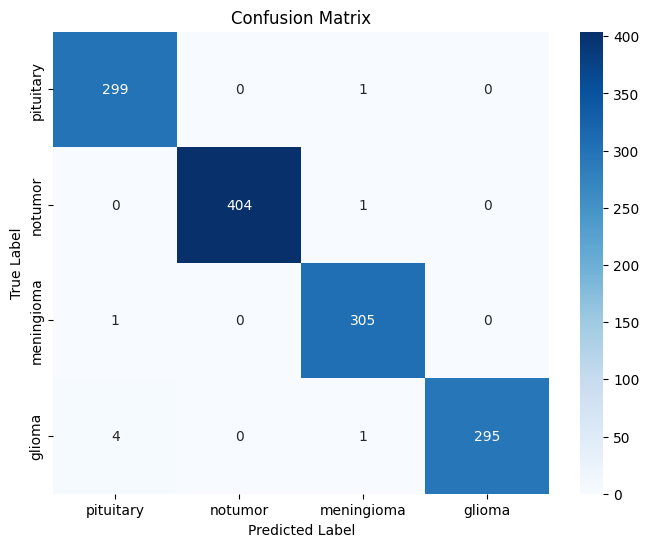

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader


def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=4))


    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
    test_dir = '/content/drive/MyDrive/newtest/Testing'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)

    test_loader = create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4)

    model = HybridResNetConvNeXt(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))

    test_model(model, test_loader, device, class_names)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


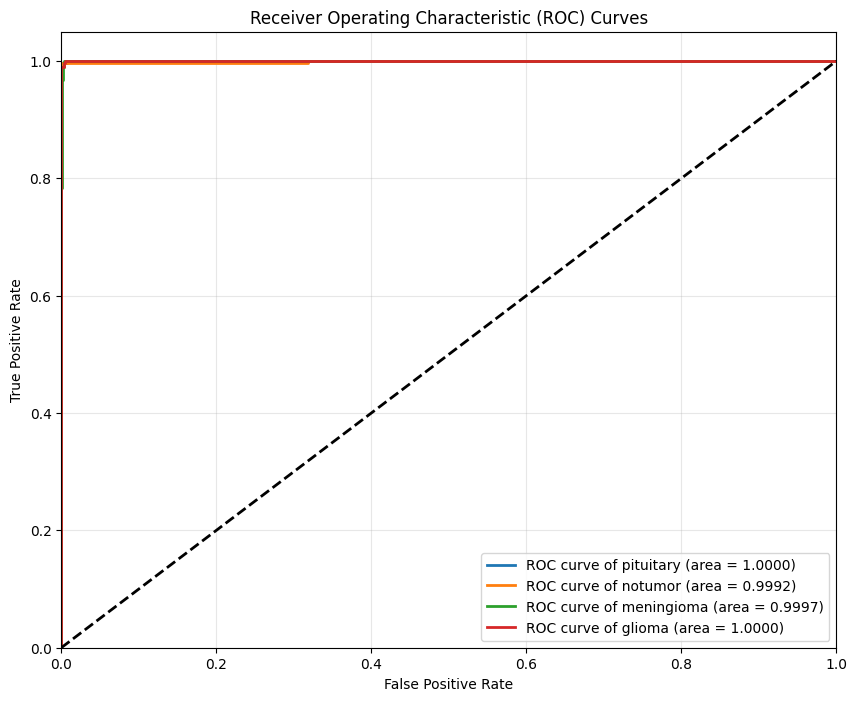

In [ ]:

from sklearn.metrics import roc_curve, auc


def compute_roc_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    num_classes = len(class_names)
    from sklearn.preprocessing import label_binarize
    binary_labels = label_binarize(all_labels, classes=range(num_classes))

    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(binary_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()



if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
    test_dir = '/content/drive/MyDrive/newtest/Testing'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)
    test_loader = create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4)

    model = HybridResNetConvNeXt(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))

    compute_roc_auc(model, test_loader, device, class_names)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader # Assuming DataLoader is needed for test_loader
import os # Assuming os is needed for file paths

# Assuming BrainTumorDataset, get_val_transforms, get_file_paths_and_labels, HybridResNetConvNeXt are defined/imported

def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader


def multiclass_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, _, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binarized_labels = label_binarize(all_labels, classes=np.arange(n_classes))

    micro_auc = roc_auc_score(binarized_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binarized_labels, all_probs, average='macro')

    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")
    for i, cname in enumerate(class_names):
        auc_score = roc_auc_score(binarized_labels[:, i], all_probs[:, i])
        print(f"AUC for class '{cname}': {auc_score:.4f}")


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names_ntest = ['pituitary', 'notumor', 'meningioma', 'glioma']
    test_dir_ntest = '/content/drive/MyDrive/newtest/Testing'

    test_image_paths_ntest, test_labels_ntest = get_file_paths_and_labels(test_dir_ntest, class_names_ntest)

    test_loader_ntest = create_test_loader(test_image_paths_ntest, test_labels_ntest, batch_size=32, num_workers=4)


    model = HybridResNetConvNeXt(num_classes=len(class_names_ntest)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))


    print("AUC scores for ntest dataset:")
    multiclass_auc(model, test_loader_ntest, device, class_names_ntest)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AUC scores for ntest dataset:
Micro-average AUC: 0.9997
Macro-average AUC: 0.9997
AUC for class 'pituitary': 1.0000
AUC for class 'notumor': 0.9992
AUC for class 'meningioma': 0.9997
AUC for class 'glioma': 1.0000


## Figshare Test Dataset

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.9932

Classification Report:
                  precision    recall  f1-score   support

 pituitary_tumor     1.0000    0.9868    0.9934       152
        no_tumor     1.0000    1.0000    1.0000       144
meningioma_tumor     0.9805    0.9934    0.9869       152
    glioma_tumor     0.9930    0.9930    0.9930       143

        accuracy                         0.9932       591
       macro avg     0.9934    0.9933    0.9933       591
    weighted avg     0.9933    0.9932    0.9932       591



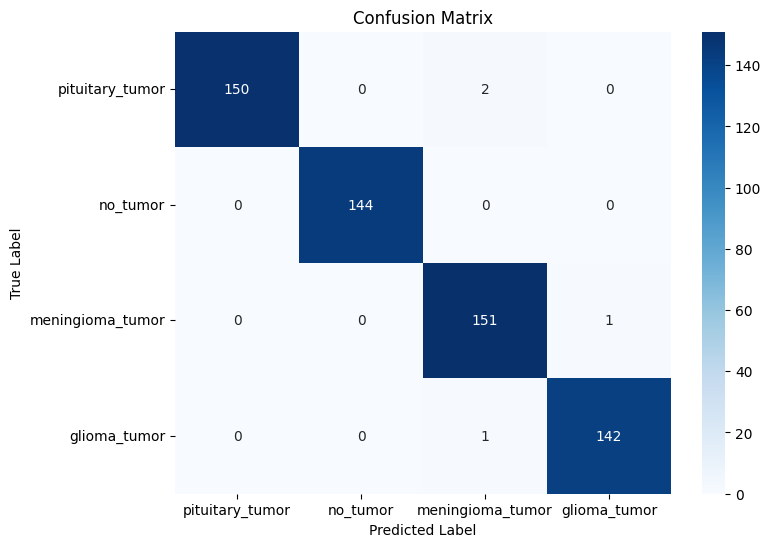

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader


def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=4))


    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
    test_dir = '/content/drive/MyDrive/ntest'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)

    test_loader = create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4)

    model = HybridResNetConvNeXt(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))

    test_model(model, test_loader, device, class_names)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


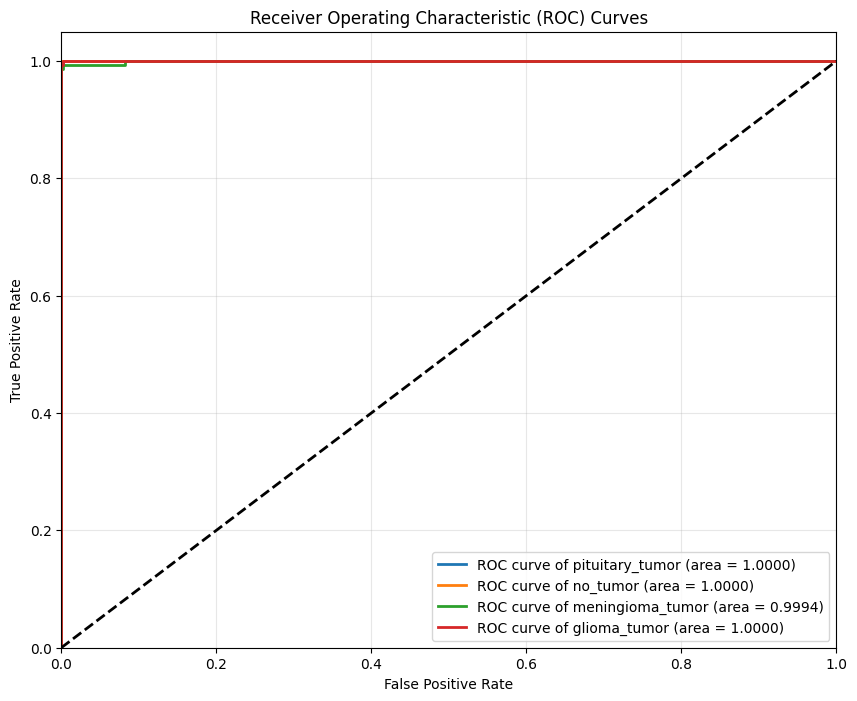

In [ ]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def compute_roc_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)  # shape (N, num_classes)
    all_labels = np.concatenate(all_labels, axis=0)  # shape (N,)

    # Binarize labels for one-vs-rest ROC
    num_classes = len(class_names)
    from sklearn.preprocessing import label_binarize
    binary_labels = label_binarize(all_labels, classes=range(num_classes))  # shape (N, num_classes)

    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(binary_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal random line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()


# Example usage:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Use class_names and test_loader from your setup
    class_names = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
    test_dir = '/content/drive/MyDrive/ntest'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)
    test_loader = create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4)

    model = HybridResNetConvNeXt(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))

    compute_roc_auc(model, test_loader, device, class_names)


In [ ]:
import torch
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

def multiclass_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, _, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binarized_labels = label_binarize(all_labels, classes=range(n_classes))

    micro_auc = roc_auc_score(binarized_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binarized_labels, all_probs, average='macro')

    print(f"Micro-average AUC score: {micro_auc:.4f}")
    print(f"Macro-average AUC score: {macro_auc:.4f}")

    for i, class_name in enumerate(class_names):
        class_auc = roc_auc_score(binarized_labels[:, i], all_probs[:, i])
        print(f"AUC for class '{class_name}': {class_auc:.4f}")

# Usage example same as previously given


In [ ]:
import torch
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize

def multiclass_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, _, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binarized_labels = label_binarize(all_labels, classes=range(n_classes))

    micro_auc = roc_auc_score(binarized_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binarized_labels, all_probs, average='macro')

    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")

    for i, cname in enumerate(class_names):
        auc_score = roc_auc_score(binarized_labels[:, i], all_probs[:, i])
        print(f"AUC of class '{cname}': {auc_score:.4f}")


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def multiclass_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, _, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binarized_labels = label_binarize(all_labels, classes=np.arange(n_classes))

    micro_auc = roc_auc_score(binarized_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binarized_labels, all_probs, average='macro')

    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")
    for i, cname in enumerate(class_names):
        auc_score = roc_auc_score(binarized_labels[:, i], all_probs[:, i])
        print(f"AUC for class '{cname}': {auc_score:.4f}")


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import os



def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader


def multiclass_auc(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, _, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binarized_labels = label_binarize(all_labels, classes=np.arange(n_classes))

    micro_auc = roc_auc_score(binarized_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binarized_labels, all_probs, average='macro')

    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")
    for i, cname in enumerate(class_names):
        auc_score = roc_auc_score(binarized_labels[:, i], all_probs[:, i])
        print(f"AUC for class '{cname}': {auc_score:.4f}")


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    class_names_ntest = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
    test_dir_ntest = '/content/drive/MyDrive/ntest'


    test_image_paths_ntest, test_labels_ntest = get_file_paths_and_labels(test_dir_ntest, class_names_ntest)


    test_loader_ntest = create_test_loader(test_image_paths_ntest, test_labels_ntest, batch_size=32, num_workers=4)


    model = HybridResNetConvNeXt(num_classes=len(class_names_ntest)).to(device)
    model.load_state_dict(torch.load('best_hybridTL_model.h5', map_location=device))

    print("AUC scores for ntest dataset:")
    multiclass_auc(model, test_loader_ntest, device, class_names_ntest)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AUC scores for ntest dataset:
Micro-average AUC: 0.9998
Macro-average AUC: 0.9999
AUC for class 'pituitary_tumor': 1.0000
AUC for class 'no_tumor': 1.0000
AUC for class 'meningioma_tumor': 0.9994
AUC for class 'glioma_tumor': 1.0000


In [ ]:
import shutil
src = '/content/best_hybridTL_model.h5'


dst = '/content/drive/MyDrive'


shutil.copy(src, dst)


'/content/drive/MyDrive/best_hybridTL_model.h5'

#TRANSFORMERS HYBRID

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/16
Train Loss: 0.6563 Acc: 0.7239 | Val Loss: 0.1698 Acc: 0.9467
Validation loss improved, saved checkpoint to best_hybridTR_model.h5
Epoch 2/16
Train Loss: 0.1512 Acc: 0.9499 | Val Loss: 0.0964 Acc: 0.9712
Validation loss improved, saved checkpoint to best_hybridTR_model.h5
Epoch 3/16
Train Loss: 0.1226 Acc: 0.9617 | Val Loss: 0.4649 Acc: 0.8339
No improvement for 1 epochs
Epoch 4/16
Train Loss: 0.0745 Acc: 0.9768 | Val Loss: 0.1415 Acc: 0.9615
No improvement for 2 epochs
Epoch 5/16
Train Loss: 0.0663 Acc: 0.9796 | Val Loss: 0.0675 Acc: 0.9755
Validation loss improved, saved checkpoint to best_hybridTR_model.h5
Epoch 6/16
Train Loss: 0.0947 Acc: 0.9757 | Val Loss: 0.0758 Acc: 0.9790
No improvement for 1 epochs
Epoch 7/16
Train Loss: 0.0502 Acc: 0.9845 | Val Loss: 0.1182 Acc: 0.9589
No improvement for 2 epochs
Epoch 8/16
Train Loss: 0.0529 Acc: 0.9845 | Val Loss: 0.0555 Acc: 0.9869
Validation loss improved, saved checkpoint to best_hybridTR_model.h5
Epoch 9/16
Train Loss: 0.049

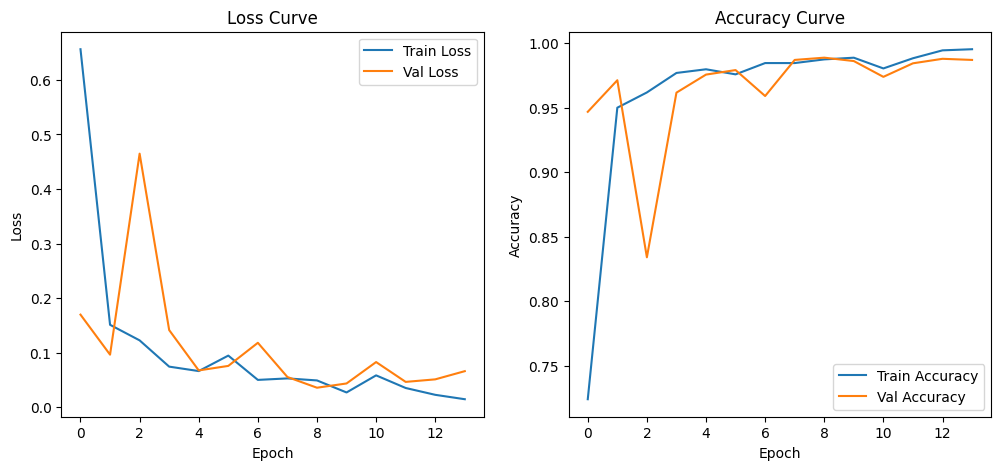

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm
import copy
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTModel


class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, seg_mask_paths=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.seg_mask_paths = seg_mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        if self.seg_mask_paths is not None and self.seg_mask_paths[idx] is not None and os.path.exists(self.seg_mask_paths[idx]):
            mask = Image.open(self.seg_mask_paths[idx]).convert('L')
            if self.transform:
                mask = self.transform(mask)
        else:
            if isinstance(img, torch.Tensor):
                mask = torch.zeros((1, img.shape[1], img.shape[2]), dtype=torch.float32)
            else:
                mask = torch.zeros((1, img.size[1], img.size[0]), dtype=torch.float32)
        return img, mask, label

def get_train_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_val_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def get_file_paths_and_labels(data_dir, class_names):
    image_paths = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(label)
    return image_paths, labels

def create_loaders_from_folders(train_images, train_labels, val_images, val_labels,
                                train_seg_masks=None, val_seg_masks=None,
                                batch_size=32, num_workers=4):
    train_dataset = BrainTumorDataset(
        image_paths=train_images,
        labels=train_labels,
        seg_mask_paths=train_seg_masks,
        transform=get_train_transforms()
    )
    val_dataset = BrainTumorDataset(
        image_paths=val_images,
        labels=val_labels,
        seg_mask_paths=val_seg_masks,
        transform=get_val_transforms()
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return train_loader, val_loader


class SwiGLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc_gate = nn.Linear(input_dim, output_dim)
        self.fc_features = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return F.silu(self.fc_gate(x)) * self.fc_features(x)


class MHCA(nn.Module):
    def __init__(self, in_channels, heads=4):
        super().__init__()
        self.heads = heads
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        batch_size, C, H, W = x.size()
        key = self.key_conv(x).view(batch_size, self.heads, C // self.heads, -1)
        query = self.query_conv(x).view(batch_size, self.heads, C // self.heads, -1)
        value = self.value_conv(x).view(batch_size, self.heads, C // self.heads, -1)
        attn = torch.matmul(query.permute(0, 1, 3, 2), key)
        attn = self.softmax(attn / (C // self.heads) ** 0.5)
        out = torch.matmul(attn, value.permute(0, 1, 3, 2))
        out = out.permute(0, 1, 3, 2).contiguous().view(batch_size, C, H, W)
        out = self.gamma * out + x
        return out


class FeatureHarmonizer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.norm1 = nn.BatchNorm1d(input_dim)
        self.fc = nn.Linear(input_dim, output_dim)
        self.norm2 = nn.LayerNorm(output_dim)
        self.activation = nn.GELU()
    def forward(self, x):
        x = self.norm1(x)
        x = self.fc(x)
        x = self.norm2(x)
        x = self.activation(x)
        return x


class HybridPoolFormerViT(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.poolformer = timm.create_model('poolformer_s12', pretrained=True, num_classes=0)
        self.mhca_poolformer = MHCA(in_channels=512, heads=8)
        self.poolformer_pool = nn.AdaptiveAvgPool2d(1)
        self.harmonizer_poolformer = FeatureHarmonizer(512, 512)

        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.harmonizer_vit = FeatureHarmonizer(self.vit.config.hidden_size, 512)

        fusion_input_dim = 512 * 2
        self.swi_glu_fc1 = SwiGLU(fusion_input_dim, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.swi_glu_fc2 = SwiGLU(512, 256)
        self.dropout2 = nn.Dropout(0.3)

        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):

        pool_feat_map = self.poolformer.forward_features(x)
        pool_feat_map = self.mhca_poolformer(pool_feat_map)
        pool_feat = self.poolformer_pool(pool_feat_map).view(x.size(0), -1)
        pool_feat = self.harmonizer_poolformer(pool_feat)


        vit_outputs = self.vit(pixel_values=x)
        vit_cls = vit_outputs.last_hidden_state[:, 0]
        vit_feat = self.harmonizer_vit(vit_cls)


        fused = torch.cat([pool_feat, vit_feat], dim=1)
        x = self.swi_glu_fc1(fused)
        x = self.dropout1(x)
        x = self.swi_glu_fc2(x)
        x = self.dropout2(x)

        logits = self.classifier(x)
        return logits


def train_model(model, train_loader, val_loader, device, epochs=16, lr=1e-4, patience=5, checkpoint_path='best_hybridTR_model.h5'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    model = model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, seg_masks, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct.double() / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())

        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, seg_masks, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct.double() / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Validation loss improved, saved checkpoint to {checkpoint_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs")
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
    train_dir = '/content/dataset_split/train'
    val_dir = '/content/dataset_split/val'

    train_image_paths, train_labels = get_file_paths_and_labels(train_dir, class_names)
    val_image_paths, val_labels = get_file_paths_and_labels(val_dir, class_names)

    train_seg_mask_paths = None
    val_seg_mask_paths = None

    train_loader, val_loader = create_loaders_from_folders(
        train_image_paths, train_labels,
        val_image_paths, val_labels,
        train_seg_masks=train_seg_mask_paths,
        val_seg_masks=val_seg_mask_paths,
        batch_size=32,
        num_workers=4
    )

    model = HybridPoolFormerViT(num_classes=len(class_names)).to(device)

    trained_model = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=16,
        lr=1e-4,
        patience=5,
        checkpoint_path='best_hybridTR_model.h5'
    )


## Kaggle Test Dataset

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader

def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader

def test_model(model, test_loader, device, class_names):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=4))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    return all_labels, all_preds


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
    test_dir = '/content/drive/MyDrive/newtest/Testing'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)

    test_loader = create_test_loader(test_image_paths, test_labels)

    model = HybridPoolFormerViT(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTR_model.h5', map_location=device))

    test_model(model, test_loader, device, class_names)

Test Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score   support

   pituitary     0.9966    0.9900    0.9933       300
     notumor     0.9975    0.9975    0.9975       405
  meningioma     0.9775    0.9935    0.9854       306
      glioma     0.9966    0.9867    0.9916       300

    accuracy                         0.9924      1311
   macro avg     0.9921    0.9919    0.9920      1311
weighted avg     0.9924    0.9924    0.9924      1311


Confusion Matrix:
[[297   0   3   0]
 [  0 404   1   0]
 [  0   1 304   1]
 [  1   0   3 296]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Test Accuracy: 0.9863

Classification Report:
              precision    recall  f1-score   support

   pituitary     0.9966    0.9867    0.9916       300
     notumor     0.9975    0.9852    0.9913       405
  meningioma     0.9620    0.9935    0.9775       306
      glioma     0.9866    0.9800    0.9833       300

    accuracy                         0.9863      1311
   macro avg     0.9857    0.9863    0.9859      1311
weighted avg     0.9865    0.9863    0.9863      1311


Confusion Matrix:
[[296   0   4   0]
 [  0 399   3   3]
 [  0   1 304   1]
 [  1   0   5 294]]


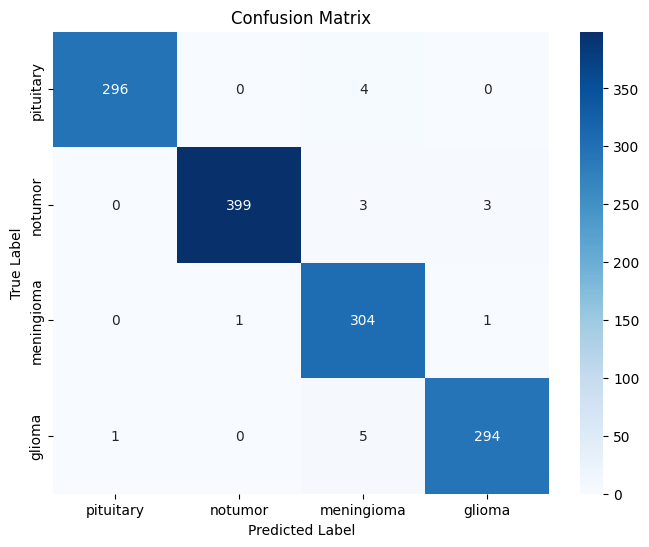

In [ ]:
y_true, y_pred = test_model(model, test_loader, device, class_names)
plot_confusion_matrix(y_true, y_pred, class_names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch


def plot_roc_curve(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)

    n_classes = len(class_names)
    binary_labels = label_binarize(all_labels, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(binary_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {class_names[i]} (area = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()




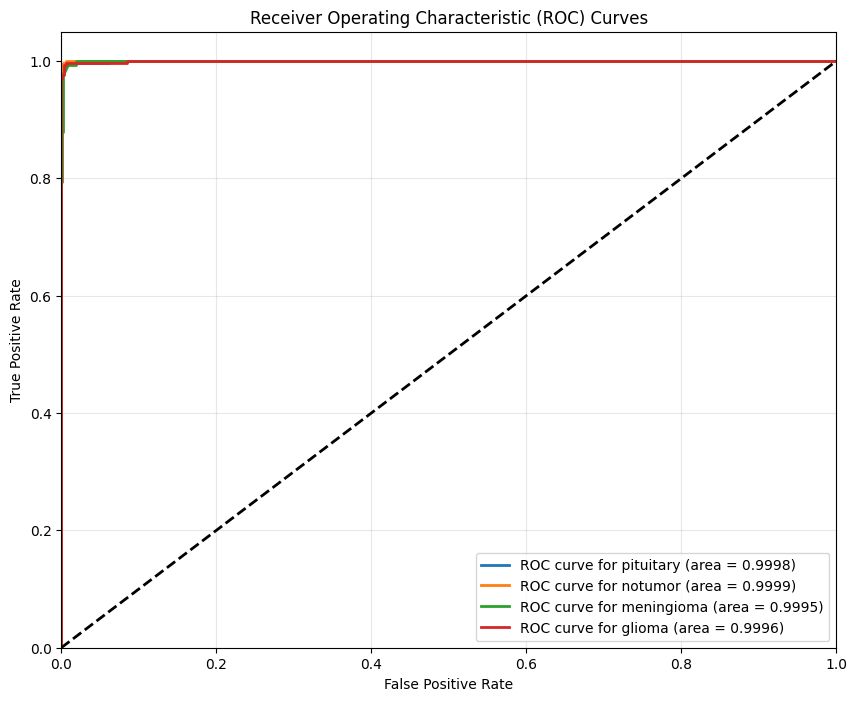

In [ ]:
plot_roc_curve(model, test_loader, device, class_names)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch

def compute_auc_score(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    n_classes = len(class_names)
    binary_labels = label_binarize(all_labels, classes=range(n_classes))


    micro_auc = roc_auc_score(binary_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binary_labels, all_probs, average='macro')

    print(f"Micro-average AUC score: {micro_auc:.4f}")
    print(f"Macro-average AUC score: {macro_auc:.4f}")

    for i, class_name in enumerate(class_names):
        try:
            class_auc = roc_auc_score(binary_labels[:, i], all_probs[:, i])
            print(f"AUC for class '{class_name}': {class_auc:.4f}")
        except ValueError as e:
            print(f"Cannot compute AUC for class '{class_name}': {e}")




In [ ]:
compute_auc_score(model, test_loader, device, class_names)

Micro-average AUC score: 0.9998
Macro-average AUC score: 0.9998
AUC for class 'pituitary': 0.9999
AUC for class 'notumor': 1.0000
AUC for class 'meningioma': 0.9996
AUC for class 'glioma': 0.9998


## Figshare Test Dataset

In [ ]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader

def create_test_loader(test_image_paths, test_labels, batch_size=32, num_workers=4):
    test_dataset = BrainTumorDataset(
        image_paths=test_image_paths,
        labels=test_labels,
        seg_mask_paths=None,
        transform=get_val_transforms()
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return test_loader

def test_model(model, test_loader, device, class_names):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=4))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    return all_labels, all_preds


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    class_names = ['pituitary_tumor', 'no_tumor', 'meningioma_tumor', 'glioma_tumor']
    test_dir = '/content/drive/MyDrive/ntest'

    test_image_paths, test_labels = get_file_paths_and_labels(test_dir, class_names)

    test_loader = create_test_loader(test_image_paths, test_labels)

    model = HybridPoolFormerViT(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load('best_hybridTR_model.h5', map_location=device))

    test_model(model, test_loader, device, class_names)

Test Accuracy: 0.9966

Classification Report:
                  precision    recall  f1-score   support

 pituitary_tumor     1.0000    0.9868    0.9934       152
        no_tumor     0.9931    1.0000    0.9965       144
meningioma_tumor     0.9935    1.0000    0.9967       152
    glioma_tumor     1.0000    1.0000    1.0000       143

        accuracy                         0.9966       591
       macro avg     0.9966    0.9967    0.9967       591
    weighted avg     0.9966    0.9966    0.9966       591


Confusion Matrix:
[[150   1   1   0]
 [  0 144   0   0]
 [  0   0 152   0]
 [  0   0   0 143]]


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch

def compute_auc_score(model, test_loader, device, class_names):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, seg_masks, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    n_classes = len(class_names)
    binary_labels = label_binarize(all_labels, classes=range(n_classes))

    micro_auc = roc_auc_score(binary_labels, all_probs, average='micro')
    macro_auc = roc_auc_score(binary_labels, all_probs, average='macro')

    print(f"Micro-average AUC score: {micro_auc:.4f}")
    print(f"Macro-average AUC score: {macro_auc:.4f}")


    for i, class_name in enumerate(class_names):
        try:
            class_auc = roc_auc_score(binary_labels[:, i], all_probs[:, i])
            print(f"AUC for class '{class_name}': {class_auc:.4f}")
        except ValueError as e:
            print(f"Cannot compute AUC for class '{class_name}': {e}")


In [ ]:
compute_auc_score(model, test_loader, device, class_names)

Micro-average AUC score: 1.0000
Macro-average AUC score: 1.0000
AUC for class 'pituitary_tumor': 1.0000
AUC for class 'no_tumor': 1.0000
AUC for class 'meningioma_tumor': 1.0000
AUC for class 'glioma_tumor': 1.0000


In [ ]:
import shutil
src = '/content/best_hybridTR_model.h5'

dst = '/content/drive/MyDrive'

shutil.copy(src, dst)

'/content/drive/MyDrive/best_hybridTR_model.h5'